In [3]:
import geopandas as gpd
import planetary_computer
import pystac_client
import dask.dataframe
import dask_geopandas as d_gpd
import dask.distributed
import shapely.geometry
import contextily as ctx
import numpy as np


In [2]:
pip install osmnx matplotlib-scalebar h3

Note: you may need to restart the kernel to use updated packages.


In [394]:
import matplotlib.pyplot as plt
import osmnx as ox
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline



In [5]:
from shapely.geometry import Polygon, Point, JOIN_STYLE
from shapely.ops import unary_union
from shapely import wkt
import h3

In [6]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [104]:

def update_environment():
    import os
    os.system("pip install h3")



In [1]:
# import dask_gateway

# cluster = dask_gateway.GatewayCluster()
# client = cluster.get_client()
# client.run(update_environment)
# cluster.adapt(minimum=2, maximum=50)

# print(cluster.dashboard_link)

In [7]:
client = dask.distributed.Client()
print(client.dashboard_link)

/user/sowelhaz@gmail.com/proxy/8787/status


In [353]:
contry='Senegal'

In [8]:
items = catalog.search(
    collections=["ms-buildings"], query={"msbuildings:region": {"eq": "Senegal"}}
)
item = next(items.items())
asset=item.assets['data']
asset

href: abfs://footprints/global/2022-07-06/ml-buildings.parquet/RegionName=Senegal
Title: Building Footprints
Description: Parquet dataset with the building footprints for this region.
Media type: application/x-parquet
Roles: ['data']
Owner:
"table:storage_options: {'account_name': 'bingmlbuildings', 'credential': 'st=2022-10-11T00%3A10%3A24Z&se=2022-10-19T00%3A10%3A24Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-10-12T00%3A10%3A23Z&ske=2022-10-19T00%3A10%3A23Z&sks=b&skv=2021-06-08&sig=qXEHvjbKWSBOqePhow8CISO1vE7FcO6D5fLyPZGau0Y%3D'}"


In [49]:
# asset = item.assets["data"]

buildings_dask = d_gpd.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
).to_crs(3857)
buildings_dask.head()

,geometry,RegionName,quadkey
0,"POLYGON ((-1665512.705 1882321.840, -1665511.6...",Senegal,33301232
1,"POLYGON ((-1665114.184 1879910.621, -1665109.4...",Senegal,33301232
2,"POLYGON ((-1665323.062 1881048.451, -1665337.6...",Senegal,33301232
3,"POLYGON ((-1665072.785 1879912.315, -1665066.7...",Senegal,33301232
4,"POLYGON ((-1678156.166 1880093.416, -1678156.9...",Senegal,33301232


In [50]:
# read a shape fie to dask_geopandas
file = d_gpd.from_geopandas(gpd.read_file('commune_sn/LIMITE_COMMUNE_SENEGAL.shp'),npartitions=4).to_crs(3857)
file.head()

,REG,DEPT,CAV,CCRCA,COD_REG,COD_DEPT,COD_CAV,COD_CCRCA,COD_ENTITE,SUPERFICIE,SUP_HA,LONGITUDE,LATITUDE,X_COORD,Y_COORD,geometry
0,DAKAR,DAKAR,DAKAR,CAMBERENE,01,1,301,44,01130144,1.762112,176.211179,-17.429062,14.768523,238510.243444,1.634138e+06,"POLYGON ((-1939718.665 1663097.367, -1939698.5..."
1,DAKAR,DAKAR,DAKAR,PARCELLES ASSAINIES,01,1,301,43,01130143,3.612295,361.229494,-17.442094,14.757746,237093.617828,1.632960e+06,"POLYGON ((-1941671.953 1662409.429, -1941628.0..."
2,DAKAR,DAKAR,DAKAR,PATTE D'OIE,01,1,301,42,01130142,3.196803,319.680255,-17.441070,14.747620,237191.773466,1.631838e+06,"POLYGON ((-1939936.286 1660309.643, -1939907.5..."
3,DAKAR,DAKAR,DAKAR,YOFF,01,1,301,33,01130133,13.855895,1385.589548,-17.479905,14.747983,233008.886700,1.631924e+06,"POLYGON ((-1945348.404 1661873.704, -1945290.6..."
4,DAKAR,DAKAR,DAKAR,NGOR,01,1,301,32,01130132,4.350230,435.023028,-17.513376,14.744756,229399.432902,1.631607e+06,"MULTIPOLYGON (((-1947935.339 1660977.516, -194..."


In [51]:
from IPython.utils.text import columnize

In [236]:
def h3_poly(x):
    
    var = h3.geo_to_h3( x.y, x.x, 9)

    return var

In [237]:
print(columnize(dir(shapely.geometry), displaywidth=100))


CAP_STYLE           MultiPolygon  __file__      asLinearRing       base             multipoint  
GeometryCollection  Point         __loader__    asMultiLineString  box              multipolygon
JOIN_STYLE          Polygon       __name__      asMultiPoint       collection       point       
LineString          __all__       __package__   asMultiPolygon     geo              polygon     
LinearRing          __builtins__  __path__      asPoint            linestring       proxy       
MultiLineString     __cached__    __spec__      asPolygon          mapping          shape       
MultiPoint          __doc__       asLineString  asShape            multilinestring  shapely     



In [131]:
print(columnize(dir(d_gpd.GeoSeries), displaywidth=100))

__abs__                           _repr_data                    isnull                      within
__add__                           _repr_divisions               iteritems                   x     
__and__                           _scalarfunc                   known_divisions             y     
__annotations__                   _skew_1d                      kurtosis                    z     
__array__                         _skew_numeric                 last                      
__array_ufunc__                   _token_prefix                 le                        
__array_wrap__                    _validate_axis                length                    
__await__                         _validate_chunks              loc                       
__bool__                          _var_1d                       lt                        
__class__                         _var_mixed                    map                       
__complex__                       _var_numeric            

In [238]:
h3_poly( shapely.geometry.Point(-14.96144,16.668920))

'89541535c27ffff'

In [239]:
buildings_dask['centroids']=(buildings_dask['geometry'].centroid.to_crs(4326))
buildings_dask['geo_h3'] = buildings_dask['centroids'].map(h3_poly, meta = ('', str))
buildings_dask['geo_h3_copy'] = buildings_dask['centroids'].map(h3_poly, meta = ('', str))
# buildings_dask['counts']=buildings_dask.groupby('geo_h3_copy')['geo_h3'].transform(lambda x: x.astype(int).count())

buildings_dask.head()


,geometry,RegionName,quadkey,centroids,geo_h3,geo_h3_copy
0,"POLYGON ((-1665512.705 1882321.840, -1665511.6...",Senegal,33301232,POINT (-14.96144 16.66892),89541535c27ffff,89541535c27ffff
1,"POLYGON ((-1665114.184 1879910.621, -1665109.4...",Senegal,33301232,POINT (-14.95791 16.64820),895415359c7ffff,895415359c7ffff
2,"POLYGON ((-1665323.062 1881048.451, -1665337.6...",Senegal,33301232,POINT (-14.95992 16.65795),895415358b7ffff,895415358b7ffff
3,"POLYGON ((-1665072.785 1879912.315, -1665066.7...",Senegal,33301232,POINT (-14.95759 16.64824),895415359c7ffff,895415359c7ffff
4,"POLYGON ((-1678156.166 1880093.416, -1678156.9...",Senegal,33301232,POINT (-15.07516 16.64979),89541520567ffff,89541520567ffff


In [109]:
dir(h3)

['H3CellError',
 'H3DistanceError',
 'H3EdgeError',
 'H3ResolutionError',
 'H3ValueError',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_cy',
 '_version',
 'api',
 'cell_area',
 'compact',
 'edge_length',
 'exact_edge_length',
 'experimental_h3_to_local_ij',
 'experimental_local_ij_to_h3',
 'geo_to_h3',
 'get_destination_h3_index_from_unidirectional_edge',
 'get_h3_indexes_from_unidirectional_edge',
 'get_h3_unidirectional_edge',
 'get_h3_unidirectional_edge_boundary',
 'get_h3_unidirectional_edges_from_hexagon',
 'get_origin_h3_index_from_unidirectional_edge',
 'get_pentagon_indexes',
 'get_res0_indexes',
 'h3',
 'h3_distance',
 'h3_get_base_cell',
 'h3_get_faces',
 'h3_get_resolution',
 'h3_indexes_are_neighbors',
 'h3_is_pentagon',
 'h3_is_res_class_III',
 'h3_is_res_class_iii',
 'h3_is_valid',
 'h3_line',
 'h3_set_to_multi_polygon',
 'h3_to_center_child',
 'h3_to_children',
 'h3_to_g

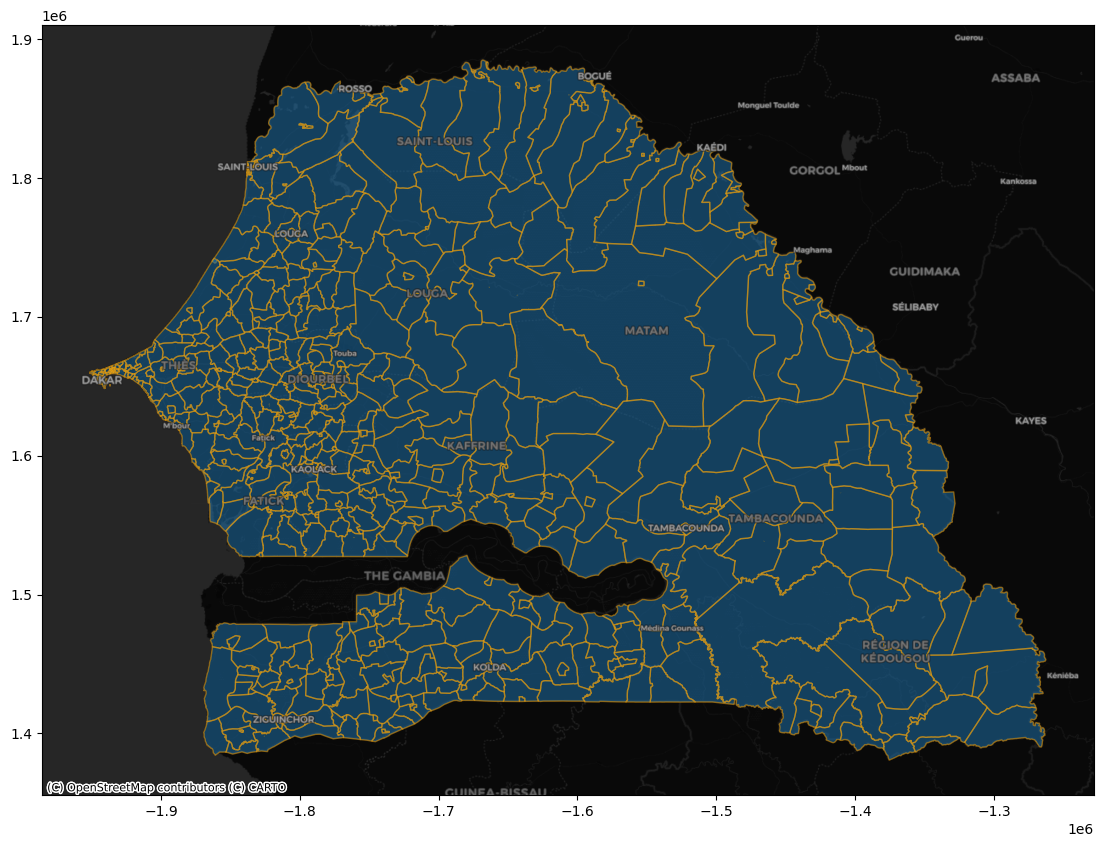

In [393]:
fig_=file.compute().plot(figsize=(14,10),alpha=0.5,edgecolor='orange')

ctx.add_basemap(fig_, crs=file.crs.to_string(), source=ctx.providers.CartoDB.DarkMatterNoLabels)
ctx.add_basemap(fig_, crs=file.crs.to_string(), source=ctx.providers.CartoDB.DarkMatterOnlyLabels)

In [400]:
city_name='dakar'

#  query city from nominatim openstreetmap

# city=ox.geocode_to_gdf(city_name)

# query city from a file
city = file[file['DEPT'] == city_name.upper()]
city=city.to_crs(3857)

In [339]:
# other analysis



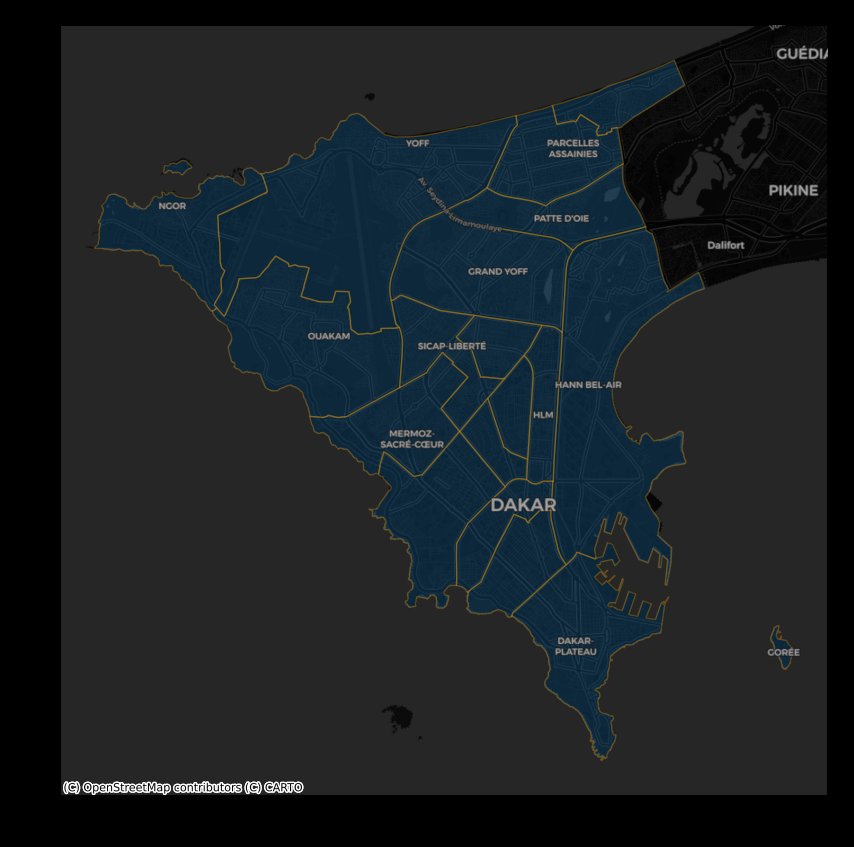

In [427]:
fig,ax=plt.subplots(facecolor='black',figsize=(10,10))

city.compute().plot(ax=ax,alpha=0.3,edgecolor='orange')

#city.plot(ax=ax, alpha=0.5, edgecolor='orange')

ctx.add_basemap(ax=ax, crs=city.crs.to_string(), source=ctx.providers.CartoDB.DarkMatterNoLabels)
ctx.add_basemap(ax=ax, crs=city.crs.to_string(), source=ctx.providers.CartoDB.DarkMatterOnlyLabels)

# ctx.add_basemap(figure, crs=city.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

In [113]:
# ax = df_dask.plot(figsize=(12, 12), color="red")
# contextily.add_basemap(
#     ax, source=contextily.providers.CartoDB.DarkMatterNoLabels, crs=df_dask.crs.to_string()
# )
# ax.set_axis_off()

In [429]:
building_in_city=d_gpd.sjoin(buildings_dask,city , how='inner')

In [325]:
building_in_city

,geometry,RegionName,quadkey,centroids,geo_h3,geo_h3_copy,index_right,REG,DEPT,CAV,CCRCA,COD_REG,COD_DEPT,COD_CAV,COD_CCRCA,COD_ENTITE,SUPERFICIE,SUP_HA,LONGITUDE,LATITUDE,X_COORD,Y_COORD
npartitions=144,,,,,,,,,,,,,,,,,,,,,,
,geometry,category[known],category[known],geometry,object,object,int64,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [430]:
buildings_=building_in_city.compute()

In [431]:
buildings=buildings_.reset_index()

In [432]:
buildings=buildings.set_index(['index'])

In [173]:
buildings

,geometry,RegionName,quadkey,centroids,geo_h3,geo_h3_copy,index_right,REG,DEPT,CAV,...,COD_DEPT,COD_CAV,COD_CCRCA,COD_ENTITE,SUPERFICIE,SUP_HA,LONGITUDE,LATITUDE,X_COORD,Y_COORD
index,,,,,,,,,,,,,,,,,,,,,
0,"POLYGON ((-1944139.820 1655667.220, -1944163.1...",Senegal,33302131,POINT (-17.46461 14.70876),8c54ac2ee59b5ff,8c54ac2ee59b5ff,11,DAKAR,DAKAR,DAKAR,...,1,301,34,01130134,3.824030,382.402952,-17.471341,14.708796,233883.794001,1.627576e+06
120,"POLYGON ((-1943702.178 1656548.561, -1943690.0...",Senegal,33302131,POINT (-17.46049 14.71665),8c54ac2eed9e1ff,8c54ac2eed9e1ff,11,DAKAR,DAKAR,DAKAR,...,1,301,34,01130134,3.824030,382.402952,-17.471341,14.708796,233883.794001,1.627576e+06
293,"POLYGON ((-1943931.818 1655799.043, -1943923.8...",Senegal,33302131,POINT (-17.46264 14.71006),8c54ac2ee5abdff,8c54ac2ee5abdff,11,DAKAR,DAKAR,DAKAR,...,1,301,34,01130134,3.824030,382.402952,-17.471341,14.708796,233883.794001,1.627576e+06
303,"POLYGON ((-1944259.234 1656700.639, -1944257.3...",Senegal,33302131,POINT (-17.46553 14.71780),8c54ac2e33027ff,8c54ac2e33027ff,11,DAKAR,DAKAR,DAKAR,...,1,301,34,01130134,3.824030,382.402952,-17.471341,14.708796,233883.794001,1.627576e+06
440,"POLYGON ((-1944152.281 1656021.569, -1944157.6...",Senegal,33302131,POINT (-17.46470 14.71189),8c54ac2e32e91ff,8c54ac2e32e91ff,11,DAKAR,DAKAR,DAKAR,...,1,301,34,01130134,3.824030,382.402952,-17.471341,14.708796,233883.794001,1.627576e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355269,"POLYGON ((-1944474.917 1657293.427, -1944480.4...",Senegal,33302131,POINT (-17.46755 14.72296),8c54ac2e3142dff,8c54ac2e3142dff,7,DAKAR,DAKAR,DAKAR,...,1,301,25,01130125,2.596523,259.652340,-17.463640,14.721350,234728.774560,1.628956e+06
355386,"POLYGON ((-1944838.140 1657766.052, -1944840.9...",Senegal,33302131,POINT (-17.47077 14.72697),8c54ac2e3c6c7ff,8c54ac2e3c6c7ff,7,DAKAR,DAKAR,DAKAR,...,1,301,25,01130125,2.596523,259.652340,-17.463640,14.721350,234728.774560,1.628956e+06
355442,"POLYGON ((-1944160.873 1657139.695, -1944156.1...",Senegal,33302131,POINT (-17.46467 14.72166),8c54ac2e3ab13ff,8c54ac2e3ab13ff,7,DAKAR,DAKAR,DAKAR,...,1,301,25,01130125,2.596523,259.652340,-17.463640,14.721350,234728.774560,1.628956e+06


In [78]:
# buildings=d_gpd.from_geopandas(buildings,npartitions=4)

In [174]:
buildings.head()

,geometry,RegionName,quadkey,centroids,geo_h3,geo_h3_copy,index_right,REG,DEPT,CAV,...,COD_DEPT,COD_CAV,COD_CCRCA,COD_ENTITE,SUPERFICIE,SUP_HA,LONGITUDE,LATITUDE,X_COORD,Y_COORD
index,,,,,,,,,,,,,,,,,,,,,
0,"POLYGON ((-1944139.820 1655667.220, -1944163.1...",Senegal,33302131,POINT (-17.46461 14.70876),8c54ac2ee59b5ff,8c54ac2ee59b5ff,11,DAKAR,DAKAR,DAKAR,...,1,301,34,01130134,3.82403,382.402952,-17.471341,14.708796,233883.794001,1.627576e+06
120,"POLYGON ((-1943702.178 1656548.561, -1943690.0...",Senegal,33302131,POINT (-17.46049 14.71665),8c54ac2eed9e1ff,8c54ac2eed9e1ff,11,DAKAR,DAKAR,DAKAR,...,1,301,34,01130134,3.82403,382.402952,-17.471341,14.708796,233883.794001,1.627576e+06
293,"POLYGON ((-1943931.818 1655799.043, -1943923.8...",Senegal,33302131,POINT (-17.46264 14.71006),8c54ac2ee5abdff,8c54ac2ee5abdff,11,DAKAR,DAKAR,DAKAR,...,1,301,34,01130134,3.82403,382.402952,-17.471341,14.708796,233883.794001,1.627576e+06
303,"POLYGON ((-1944259.234 1656700.639, -1944257.3...",Senegal,33302131,POINT (-17.46553 14.71780),8c54ac2e33027ff,8c54ac2e33027ff,11,DAKAR,DAKAR,DAKAR,...,1,301,34,01130134,3.82403,382.402952,-17.471341,14.708796,233883.794001,1.627576e+06
440,"POLYGON ((-1944152.281 1656021.569, -1944157.6...",Senegal,33302131,POINT (-17.46470 14.71189),8c54ac2e32e91ff,8c54ac2e32e91ff,11,DAKAR,DAKAR,DAKAR,...,1,301,34,01130134,3.82403,382.402952,-17.471341,14.708796,233883.794001,1.627576e+06


In [433]:

buildings['counts']=buildings.groupby('geo_h3_copy')['geo_h3'].transform(lambda x: x.count())


In [434]:
buildings['areas']=buildings.geometry.area

In [358]:
em = h3.hex_area(resolution=9,unit='m^2')
em

105332.5

In [161]:
 h3.hex_area?

Signature: h3.hex_area(resolution, unit='km^2')
Docstring:
Return the average area of an H3 *hexagon*
for the given resolution.

This average *excludes* pentagons.

Returns
-------
float
File:      /srv/conda/envs/notebook/lib/python3.10/site-packages/h3/api/_api_template.py
Type:      function


In [435]:
buildings['buildings_area']=buildings.groupby('geo_h3_copy')['areas'].transform(lambda x: x.sum())

In [436]:
buildings['scale']=(buildings['buildings_area']/em)

In [314]:
# buildings['scale']=buildings['scale_']/(buildings['scale_'].sum())

In [437]:
buildings['scale'].max(),buildings['scale'].min()

(0.6088908886894138, 0.0001939965809353196)

In [265]:
# datashader hvplot

buildings


,geometry,RegionName,quadkey,centroids,geo_h3,geo_h3_copy,index_right,REG,DEPT,CAV,...,SUPERFICIE,SUP_HA,LONGITUDE,LATITUDE,X_COORD,Y_COORD,counts,areas,buildings_area,scale
index,,,,,,,,,,,,,,,,,,,,,
3,"POLYGON ((-1936815.311 1660067.366, -1936851.1...",Senegal,33302131,POINT (-17.39898 14.74702),8954ac250bbffff,8954ac250bbffff,38,DAKAR,PIKINE,PIKINE,...,1.985733,198.573337,-17.399841,14.750798,241636.597163,1.632142e+06,119,1873.359773,28680.732007,32.402223
305,"POLYGON ((-1937116.718 1660412.987, -1937120.8...",Senegal,33302131,POINT (-17.40148 14.75007),8954ac2508fffff,8954ac2508fffff,38,DAKAR,PIKINE,PIKINE,...,1.985733,198.573337,-17.399841,14.750798,241636.597163,1.632142e+06,168,85.210534,36521.908293,58.250593
760,"POLYGON ((-1937746.981 1660507.873, -1937754.6...",Senegal,33302131,POINT (-17.40712 14.75085),8954ac250c7ffff,8954ac250c7ffff,38,DAKAR,PIKINE,PIKINE,...,1.985733,198.573337,-17.399841,14.750798,241636.597163,1.632142e+06,120,75.855614,27129.373832,30.907126
995,"POLYGON ((-1936275.139 1660252.511, -1936269.2...",Senegal,33302131,POINT (-17.39381 14.74873),8954ac250b7ffff,8954ac250b7ffff,38,DAKAR,PIKINE,PIKINE,...,1.985733,198.573337,-17.399841,14.750798,241636.597163,1.632142e+06,172,159.271971,31345.401323,51.184668
1089,"POLYGON ((-1937247.988 1660029.138, -1937240.3...",Senegal,33302131,POINT (-17.40255 14.74675),8954ac25017ffff,8954ac25017ffff,38,DAKAR,PIKINE,PIKINE,...,1.985733,198.573337,-17.399841,14.750798,241636.597163,1.632142e+06,131,55.088374,25335.004099,31.508656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354980,"POLYGON ((-1935547.030 1660388.338, -1935540.1...",Senegal,33302131,POINT (-17.38728 14.74991),8954ac25573ffff,8954ac25573ffff,37,DAKAR,PIKINE,PIKINE,...,1.290602,129.060184,-17.387150,14.747112,242999.267803,1.631719e+06,313,90.236572,33911.252271,100.768727
355011,"POLYGON ((-1935896.415 1660403.830, -1935904.2...",Senegal,33302131,POINT (-17.39061 14.74983),8954ac2557bffff,8954ac2557bffff,37,DAKAR,PIKINE,PIKINE,...,1.290602,129.060184,-17.387150,14.747112,242999.267803,1.631719e+06,253,413.452193,25442.640510,61.111130
355077,"POLYGON ((-1935882.723 1660193.655, -1935884.2...",Senegal,33302131,POINT (-17.39037 14.74821),8954ac2557bffff,8954ac2557bffff,37,DAKAR,PIKINE,PIKINE,...,1.290602,129.060184,-17.387150,14.747112,242999.267803,1.631719e+06,253,213.813562,25442.640510,61.111130


In [20]:
buildings.explore?

Signature: buildings.explore(*args, **kwargs)
Docstring:
Interactive map based on folium/leaflet.jsInteractive map based on GeoPandas and folium/leaflet.js

Generate an interactive leaflet map based on :class:`~geopandas.GeoDataFrame`

Parameters
----------
column : str, np.array, pd.Series (default None)
    The name of the dataframe column, :class:`numpy.array`,
    or :class:`pandas.Series` to be plotted. If :class:`numpy.array` or
    :class:`pandas.Series` are used then it must have same length as dataframe.
cmap : str, matplotlib.Colormap, branca.colormap or function (default None)
    The name of a colormap recognized by ``matplotlib``, a list-like of colors,
    :class:`matplotlib.colors.Colormap`, a :class:`branca.colormap.ColorMap` or
    function that returns a named color or hex based on the column
    value, e.g.::

        def my_colormap(value):  # scalar value defined in 'column'
            if value > 1:
                return "green"
            return "red"

color : 

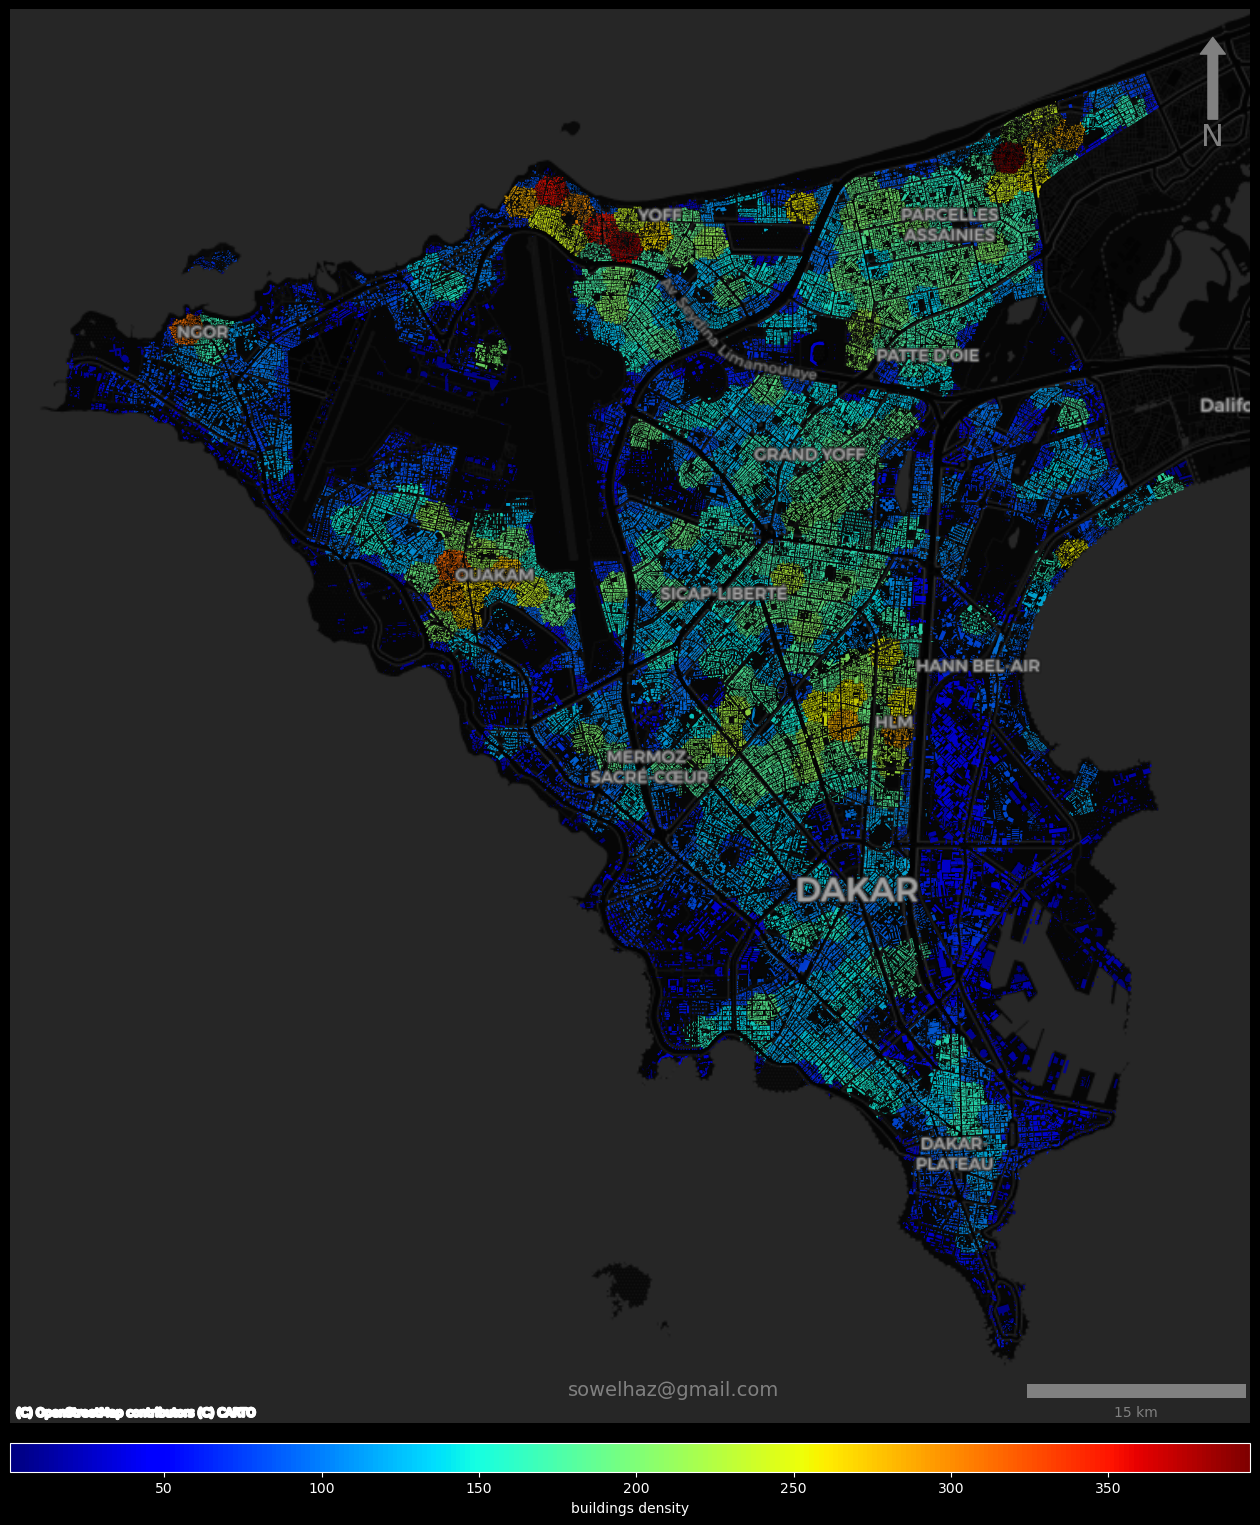

In [454]:
fig,ax=plt.subplots(1,1,figsize =(16,20),facecolor='black')

ax.set_facecolor('grey')

plt.style.use("dark_background")

divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="2%", pad=0.2)
                         
# city.plot(ax=ax,alpha=.7,color='none',edgecolor = 'orange',aspect=1)  

buildings.plot(ax=ax,alpha=.8,cmap='jet',
               legend=True,
               column=buildings['counts'],
               legend_kwds={'label': "buildings density",
                        'orientation': "horizontal"},cax=cax,aspect=1)

# ax.legend(labelcolor='w')
# cx.add_basemap(figu,crs=km.crs,source=cx.providers.Stamen.TonerLite)

ctx.add_basemap(ax, crs=buildings.crs.to_string(), source=ctx.providers.CartoDB.DarkMatterNoLabels)
ctx.add_basemap(ax, crs=buildings.crs.to_string(), source=ctx.providers.CartoDB.DarkMatterOnlyLabels)



# Flèche Nord
x, y, arrow_length = 0.97, 0.98, 0.07
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='grey', width=7, headwidth=18,edgecolor='grey'),
            ha='center', va='center', fontsize=22,color='grey',
            xycoords=ax.transAxes)
ax.add_artist(ScaleBar(6,box_alpha = 0,location='lower right',color='grey'))


# ax.tick_params(labelcolor='tab:orange',labelsize=15)

ax.set_axis_off()



# ax.text(0.1,0.3,'DAKAR',fontsize=70,color='grey',transform=ax.transAxes,style='italic')
# ax.text(0.135,0.27,'SENEGAL',fontsize=35,color='grey',transform=ax.transAxes,style='italic')
ax.text(0.45,0.02,'sowelhaz@gmail.com',fontsize=14,color='grey',transform=ax.transAxes)

plt.savefig('dakar_dept_jet_counts.png',dpi=250)

In [120]:
cluster.close()